In [1]:
import mne
from scipy import fftpack
from scipy.fft import fft
from scipy.signal import resample
from skimage import util
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
raw_data = mne.io.read_raw_edf('data/test2.edf', preload=True)

Extracting EDF parameters from D:\sleepscoring\data\test2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43199999  =      0.000 ... 86399.998 secs...


In [5]:
raw_data.info['meas_date'].hour

10

In [6]:
annotations = mne.read_annotations('test_edfplus.edf')

FileNotFoundError: fname "test_edfplus.edf" does not exist

In [12]:
df = raw_data.to_data_frame()
df.columns = ['time','activity','eeg','emg','signal_str','temp','sleep_stage']
df['sleep_stage']=df['sleep_stage']/1e6
df['sleep_stage']=df['sleep_stage'].round()
df['temp']=(df['temp']/1e7).round(4)
print(df.head())

stage_names ={1.0:'awake',
              2.0:'PS',
              3.0:'SWS',
              10.0:"Artifact"}

   time     activity        eeg       emg    signal_str    temp  sleep_stage
0     0  1953.184606 -81.942198 -3.509629  3.499985e+07  3.4175          3.0
1     2  1953.184606 -73.091830 -6.561480  3.500183e+07  3.4175          3.0
2     4  1953.184606 -65.004425 -3.967406  3.500383e+07  3.4175          3.0
3     6  1953.184606 -55.696280 -0.457778  3.500584e+07  3.4175          3.0
4     8  1953.184606 -39.674062 -0.457778  3.500786e+07  3.4175          3.0


In [13]:
df['sleep_stage'].value_counts()

1.0     20920000
3.0     19255000
2.0      2560000
10.0      465000
Name: sleep_stage, dtype: int64

In [30]:
df.shape[0]/(6*60*24)

In [60]:
sleep_stages = []
for i in range(8640):
    sleep_stages.append(df.sleep_stage[i*5000:(i+1)*5000].mean())

In [176]:
df_new = pd.DataFrame()

data_dict =  {'time':[],
              'eeg':[],
              'emg':[],
              'signal_str':[],
              'sleep_stage':[]}


for i in range(6*60*24):
    data_dict['time'].append(df.time[i*5000])
    data_dict['eeg'].append(df.eeg[i*5000:(i+1)*5000].values)
    data_dict['emg'].append(df.emg[i*5000:(i+1)*5000].values)
    data_dict['signal_str'].append(df.signal_str[i*5000:(i+1)*5000].values)
    data_dict['sleep_stage'].append(df.sleep_stage[i*5000])
    

In [256]:
def rectified_std(array):
    return(np.std(np.abs(array)))

def rectified_mean(array):
    return(np.mean(np.abs(array)))
    

In [177]:
df2 = pd.DataFrame.from_dict(data_dict)

In [257]:
df2['eeg_max'] = df2['eeg'].apply(np.max)
df2['eeg_min'] = df2['eeg'].apply(np.min)
df2['eeg_mean'] = df2['eeg'].apply(np.mean)
df2['eeg_std'] = df2['eeg'].apply(np.std)
df2['reeg_std'] = df2['eeg'].apply(rectified_std)

In [258]:
df2['emg_max'] = df2['emg'].apply(np.max)
df2['emg_min'] = df2['emg'].apply(np.min)
df2['emg_mean'] = df2['emg'].apply(np.mean)
df2['emg_std'] = df2['emg'].apply(np.std)
df2['remg_std'] = df2['emg'].apply(rectified_std)

Text(0.5, 1.0, 'Rectified')

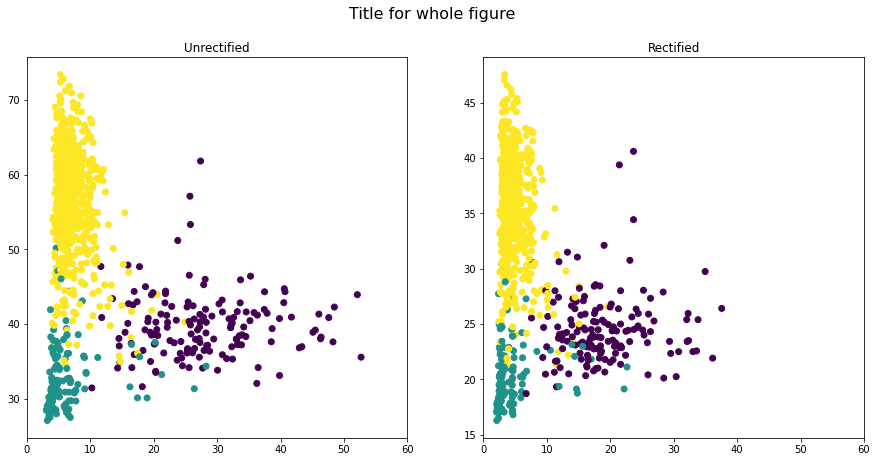

In [280]:
fig, ax = plt.subplots(1,2, figsize=(15, 7))
fig.suptitle("Title for whole figure", fontsize=16)
ax[0].scatter(df2['emg_std'][0:1000],df2['eeg_std'][0:1000], c=df2['sleep_stage'][0:1000])
ax[0].set_xlim((0,60))
ax[0].title.set_text('Unrectified')
ax[1].scatter(df2['remg_std'][0:1000],df2['reeg_std'][0:1000], c=df2['sleep_stage'][0:1000])
ax[1].set_xlim((0,60))
ax[1].set_title('Rectified')

In [192]:
df2.head()

,time,eeg,emg,signal_str,sleep_stage,eeg_max,eeg_min,eeg_mean,eeg_std
0,0,"[-81.94219794305246, -73.09183019501327, -65.0...","[-3.5096285897396773, -6.561479537339396, -3.9...","[34999847.40745262, 35001829.06457086, 3500382...",3.0,312.509537,-244.911039,-0.917081,61.102474
1,10000,"[88.65627002777184, 81.02664265877254, 69.4296...","[11.749626148258919, 6.40888698995941, 1.37333...","[34999847.40745261, 35001522.62981798, 3500319...",3.0,353.556932,-177.159948,0.469924,59.819381
2,20000,"[45.31998657185583, 46.388134403515735, 44.557...","[-5.493331705679495, -3.357036042359691, -3.35...","[34999847.40745263, 34999942.272665404, 350000...",3.0,249.488815,-258.186590,-0.268838,60.604688
3,30000,"[15.86962492751854, -10.071108127079073, -40.2...","[-3.967406231879635, 3.662221137119663, 6.8666...","[34998016.29688405, 34997360.18338733, 3499669...",3.0,281.838435,-236.518448,-0.605731,65.837213
4,40000,"[-96.28589739677115, -110.32441175572986, -119...","[-2.1362956633198036, -0.3051850947599719, -0....","[34999847.40745262, 34997565.92489864, 3499514...",3.0,270.851772,-160.374767,0.814844,62.723396


(-300.0, 300.0)

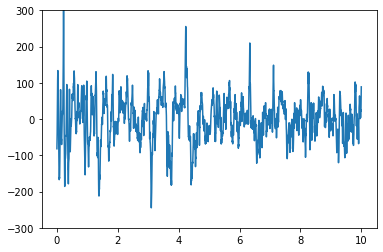

In [205]:
start = 0
bins = 1
stop = start*5000+(bins*5000)
N=5000
T = 1.0/500.0
x = df.time[5000*start:stop]
y = df.eeg[5000*start:stop]
yf = fft(y.values)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.plot(x/1000,y)
plt.ylim((-300,300))


(-100.0, 200.0)

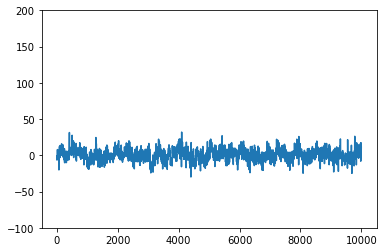

In [206]:
plt.plot(x,df.emg[5000*start:stop])
plt.ylim((-100,200))

(0.0, 20.0)

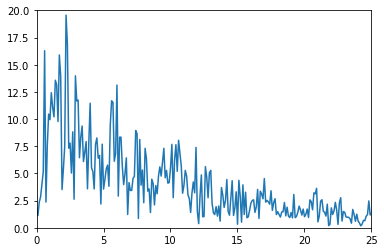

In [207]:
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim((0,25))
plt.ylim((0,20))

In [208]:
yf_hamming = yf.hamming(512)
x_hamming = np.linspace(0.0, 1.0/(2.0*T),512)
plt.plot(x_hamming, yf_hamming)

AttributeError: 'numpy.ndarray' object has no attribute 'hamming'

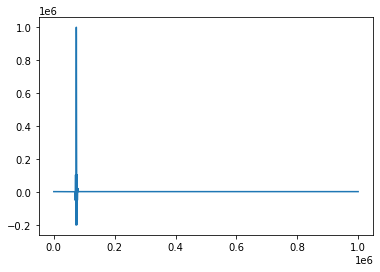

In [146]:
plt.plot(df.time[start:stop],df.activity[start:stop])

In [153]:
rx = resample(xf,512)

In [167]:
ry = resample(yas,1024)

In [166]:

yas = 2.0/N * np.abs(yf[0:N//2])

(0.0, 25.0)

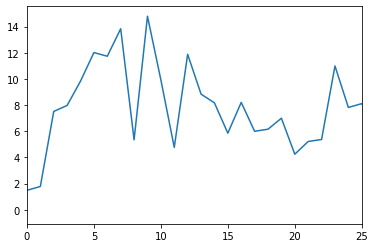

In [168]:
plt.plot(ry)
plt.xlim(0,25)

In [219]:
M = 1024

  Using cached networkx-2.4-py3-none-any.whl (1.6 MB)


In [224]:
slices = util.view_as_windows(np.array(y), window_shape=(M,), step=512)

In [225]:
slices.shape

(8, 1024)

In [226]:
y.shape

(5000,)

In [227]:
win = np.hamming(M + 1)[:-1]
slices = slices * win

In [228]:
slices = slices.T

In [229]:
slices.shape

(1024, 8)

In [230]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

In [231]:
spectrum.shape

(510, 8)

4


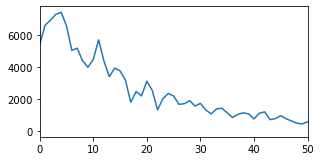

In [247]:
f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
z = S.mean(axis=1)


ax.plot(S.mean(axis=1))
ax.set_xlim(0,50)
print(z.argmax())

EEG Power ratio 1
5-9 Hz / 0.5-4.5 Hz

EEG Power ratio 2
0.5-20 Hz / 0.5-55
Hz

Mean amplitude of
rectified EMG